In [49]:
import numpy as np
import data
import models
import cache
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [7]:
model_name = 'model6.2'
by = 'SubSet'
sample_n = 100 ## number genes
#test_sample_n = 1 ## number out of sample samples
#train_sample_n = None

In [8]:
sample_df = cache.cached(models.prep_sample_df,
                         sample_n=sample_n)

INFO:stancache.stancache:prep_sample_df: cache_filename set to prep_sample_df.cached.sample_n_100.pkl
INFO:stancache.stancache:prep_sample_df: Loading result from cache


In [9]:
sample_df.SubSet.unique()

array(['CD4_Th2', 'CD8_Effector', 'B_CD5', 'B_Memory', 'CD4_Th1',
       'CD4_Naive', 'B_Naive', 'CD4_Effector_Memory', 'CD8_Central_Memory',
       'CD4_Central_Memory', 'CD4_Treg', 'CD8_Naive', 'CD4_Th17'], dtype=object)

In [10]:
# make training_df = sample_df, test_df = some synthetic mixtures
# first let's try making these mixtures manually

"""
notes from before about how we want to do this:
take raw lines, add them straight up with weights
naive B cells, memory B cells
(CD8, CD4)
Tregs vs naive B cells

first level of noise: gaussian noise on every transcript after the sum
so take mix1 + np.random.normal(0,1,len(mix1))
doesn't feel like enough noise tbh

second level of noise: vary the mixture weights for each transcript individually
weights_noisy = np.reshape(weights*len(mix1), reference[simple_cols].shape)
weights_noisy += np.abs(np.random.normal(0,0.1, weights_noisy.shape))
weights_noisy = weights_noisy.clip(0,1)
mix3=(weights_noisy * reference[simple_cols]).sum(axis=1)
mix3.head()

"""

training_df = sample_df

relevant_sample_ids = {
    'B_Naive': sample_df[sample_df['SubSet'] == 'B_Naive'].new_sample_id.unique(),
    'B_Memory': sample_df[sample_df['SubSet'] == 'B_Memory'].new_sample_id.unique(),
    'CD4_Treg': sample_df[sample_df['SubSet'] == 'CD4_Treg'].new_sample_id.unique(),
}
assert all([len(relevant_sample_ids[i]) > 0 for i in relevant_sample_ids])

bnaive_line = sample_df[sample_df['new_sample_id'] == relevant_sample_ids['B_Naive'][0]].copy()
bmemory_line = sample_df[sample_df['new_sample_id'] == relevant_sample_ids['B_Memory'][0]].copy()

weights = np.array([.25, .75])
weights = weights / np.sum(weights) # normalize
print('weights:', weights)
bnaive_line.loc[:,'est_counts'] *= weights[0]
bmemory_line.loc[:,'est_counts'] *= weights[1]
mixed_sample = pd.concat([bnaive_line, bmemory_line]).groupby(
    ['gene_name', 'new_gene_id'])['est_counts'].sum().reset_index()
mixed_sample.head(n=15)

weights: [ 0.25  0.75]


,gene_name,new_gene_id,est_counts
0,AC013470.6,1,1.251623
1,AC018634.9,2,0.750000
2,AC078899.4,3,0.000000
3,AC108059.2,4,0.000000
4,ACTR3BP3,5,0.000000
5,AF277315.13,6,0.000000
6,AFTPH,7,1803.217175
7,AIFM3,8,35.750015
8,ATP1A1,9,3188.239605
9,BBS7,10,23.749966


In [11]:
# sanity check
a=sample_df[(sample_df['new_sample_id'] == relevant_sample_ids['B_Naive'][0]) & (sample_df['gene_name'] == 'AFTPH')]['est_counts'].values[0]
b=sample_df[(sample_df['new_sample_id'] == relevant_sample_ids['B_Memory'][0]) & (sample_df['gene_name'] == 'AFTPH')]['est_counts'].values[0]
computed=mixed_sample[mixed_sample['gene_name'] == 'AFTPH']['est_counts'].values[0]
sanity_sum = weights[0] * a + weights[1] * b
print('b naive value', a)
print('b memory value', b)
print('weights[0] * a + weights[1] * b = ', sanity_sum)
print('computed:', computed)
assert sanity_sum == computed, 'Issue with the weighted average'
print('passed automatic sanity check')

b naive value 1414.6883
b memory value 1932.7268
weights[0] * a + weights[1] * b =  1803.217175
computed: 1803.217175
passed automatic sanity check


In [12]:
# let's try running this thru stan now
# first, compress training_df -> small-training_df

# first, let's just sample a couple samples for now
#small_training_df=training_df.sample(n=10).copy() # this just loses genes, bad

all_train_samples = training_df.new_sample_id.unique()
print('number of training samples total:', len(all_train_samples))
print('total number of subsets in full training set:', len(training_df.SubSet.unique()))

#subset_of_samples = np.random.choice(all_train_samples, size=10)
#small_training_df = training_df[training_df['new_sample_id'].isin(subset_of_samples)]
#print('filtered to 10 samples that are from these subsets:', small_training_df.SubSet.unique())

# instead choose one sample from each subset
chosen_sample_ids = training_df.groupby('SubSet')['new_sample_id'].first().values
assert len(chosen_sample_ids) == len(training_df.SubSet.unique())
small_training_df = training_df[training_df['new_sample_id'].isin(chosen_sample_ids)].copy()
small_training_df

number of training samples total: 63
total number of subsets in full training set: 13


,index,sample_id,filename,gene_name,est_counts,tpm,log1p_tpm,log1p_counts,CCR6+,CCR7+,...,log1p_tpm_rescaled_subset,log1p_tpm_rescaled,gene_cat,gene_id,B_cell,T_cell,new_gene_cat,new_gene_id,new_sample_cat,new_sample_id
0,0,1,ERR431566,AC013470.6,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,-0.365810,AC013470.6,741,0,1,AC013470.6,1,1,1
1,1,2,ERR431567,AC013470.6,1.001920,0.208057,0.189013,0.694107,0.0,0.0,...,1.791158,2.547926,AC013470.6,741,0,1,AC013470.6,1,2,2
2,2,3,ERR431568,AC013470.6,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,-0.855109,-0.365810,AC013470.6,741,1,0,AC013470.6,1,3,3
3,3,4,ERR431569,AC013470.6,1.000000,0.105188,0.100015,0.693147,0.0,0.0,...,1.157821,1.175979,AC013470.6,741,1,0,AC013470.6,1,4,4
4,4,5,ERR431570,AC013470.6,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,-0.365810,AC013470.6,741,0,1,AC013470.6,1,5,5
5,5,6,ERR431571,AC013470.6,0.000000,0.000000,0.000000,0.000000,0.0,1.0,...,0.000000,-0.365810,AC013470.6,741,0,1,AC013470.6,1,6,6
6,6,7,ERR431572,AC013470.6,2.006490,0.391670,0.330504,1.100773,0.0,0.0,...,2.150747,4.729085,AC013470.6,741,1,0,AC013470.6,1,7,7
9,9,10,ERR431575,AC013470.6,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,-0.365810,AC013470.6,741,0,1,AC013470.6,1,10,10
12,12,13,ERR431578,AC013470.6,0.000000,0.000000,0.000000,0.000000,0.0,1.0,...,0.000000,-0.365810,AC013470.6,741,0,1,AC013470.6,1,13,13
16,16,17,ERR431582,AC013470.6,0.000000,0.000000,0.000000,0.000000,0.0,1.0,...,-0.496225,-0.365810,AC013470.6,741,0,1,AC013470.6,1,17,17


In [13]:
small_training_df[by].head()

0         CD4_Th2
1    CD8_Effector
2           B_CD5
3        B_Memory
4         CD4_Th1
Name: SubSet, dtype: object

In [14]:
test_df = mixed_sample.copy()
test_df['sample_id'] = 10001
test_df['gene_id'] = test_df['new_gene_id']

#for dat in [small_training_df, test_df]:
for dat in [training_df, test_df]:
    dat.sort_values(['gene_id','sample_id'], inplace=True)
    dat['new_sample_cat'] = dat['sample_id'].astype('category')
    dat['new_sample_id'] = dat['new_sample_cat'].cat.codes+1

test_df

,gene_name,new_gene_id,est_counts,sample_id,gene_id,new_sample_cat,new_sample_id
0,AC013470.6,1,1.251623,10001,1,10001,1
1,AC018634.9,2,0.750000,10001,2,10001,1
2,AC078899.4,3,0.000000,10001,3,10001,1
3,AC108059.2,4,0.000000,10001,4,10001,1
4,ACTR3BP3,5,0.000000,10001,5,10001,1
5,AF277315.13,6,0.000000,10001,6,10001,1
6,AFTPH,7,1803.217175,10001,7,10001,1
7,AIFM3,8,35.750015,10001,8,10001,1
8,ATP1A1,9,3188.239605,10001,9,10001,1
9,BBS7,10,23.749966,10001,10,10001,1


In [15]:
model_file = models.get_model_file(model_name=model_name)
#print(cache._read_file(model_file))

In [16]:
#stan_data = models.prep_stan_data(sample_df=small_training_df, test_df=None, by=by)
stan_data = models.prep_stan_data(sample_df=training_df, test_df=None, by=by)

stan_data

{'C': 13,
 'G': 100,
 'M': 20,
 'N': 6300,
 'S': 63,
 'cell_features':                      CCR6+  CCR7+  CCR7-  CD127-  CD161+  CD19+  CD25+  CD27+  \
 SubSet                                                                          
 CD4_Th2                0.0    0.0    0.0     0.0     0.0    0.0    0.0    0.0   
 CD8_Effector           0.0    0.0    1.0     0.0     0.0    0.0    0.0    0.0   
 B_CD5                  0.0    0.0    0.0     0.0     0.0    1.0    0.0    0.0   
 B_Memory               0.0    0.0    0.0     0.0     0.0    1.0    0.0    1.0   
 CD4_Th1                0.0    0.0    0.0     0.0     0.0    0.0    0.0    0.0   
 CD4_Naive              0.0    1.0    0.0     0.0     0.0    0.0    0.0    0.0   
 B_Naive                0.0    0.0    0.0     0.0     0.0    1.0    0.0    0.0   
 CD4_Effector_Memory    0.0    0.0    1.0     0.0     0.0    0.0    0.0    0.0   
 CD8_Central_Memory     0.0    1.0    0.0     0.0     0.0    0.0    0.0    0.0   
 CD4_Central_Memory     0.0 

In [17]:
stan_data['x']

,SubSet[B_CD5],SubSet[B_Memory],SubSet[B_Naive],SubSet[CD4_Central_Memory],SubSet[CD4_Effector_Memory],SubSet[CD4_Naive],SubSet[CD4_Th1],SubSet[CD4_Th17],SubSet[CD4_Th2],SubSet[CD4_Treg],SubSet[CD8_Central_Memory],SubSet[CD8_Effector],SubSet[CD8_Naive]
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
x2_data = pd.DataFrame(np.zeros((1, stan_data['x'].shape[1])), columns=stan_data['x'].columns)
x2_data['SubSet[B_Naive]'] = weights[0]
x2_data['SubSet[B_Memory]'] = weights[1]
x2_data

,SubSet[B_CD5],SubSet[B_Memory],SubSet[B_Naive],SubSet[CD4_Central_Memory],SubSet[CD4_Effector_Memory],SubSet[CD4_Naive],SubSet[CD4_Th1],SubSet[CD4_Th17],SubSet[CD4_Th2],SubSet[CD4_Treg],SubSet[CD8_Central_Memory],SubSet[CD8_Effector],SubSet[CD8_Naive]
0,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#relevant_sample_ids

def get_sample_ids_by_subset(sample_df):
    return {subset: 
            sample_df[sample_df['SubSet'] == subset].new_sample_id.unique() for subset in sample_df.SubSet.unique()}
relevant_sample_ids = get_sample_ids_by_subset(sample_df)
relevant_sample_ids

{'B_CD5': array([ 3, 26, 31, 34]),
 'B_Memory': array([ 4, 29, 43, 48, 52]),
 'B_Naive': array([ 7, 21, 46, 54, 59]),
 'CD4_Central_Memory': array([17, 33, 49, 55, 61]),
 'CD4_Effector_Memory': array([10, 11, 23, 38, 51]),
 'CD4_Naive': array([ 6,  9, 15, 16, 45]),
 'CD4_Th1': array([ 5, 12, 19, 22, 57]),
 'CD4_Th17': array([30, 32, 39, 53, 60]),
 'CD4_Th2': array([ 1, 14, 35, 50, 63]),
 'CD4_Treg': array([18, 24, 36, 41, 44]),
 'CD8_Central_Memory': array([13, 28, 37, 42]),
 'CD8_Effector': array([ 2,  8, 20, 25, 56]),
 'CD8_Naive': array([27, 40, 47, 58, 62])}

In [20]:
# wrap above manual work into a function

def mix_cell_lines(xdata, subsets, weights, sample_ids=None, new_sample_id=10001):
    """
    e.g. xdata=stan_data['x'], subsets=['B_Naive', 'B_Memory'], weights=[.5, .5], sample_ids=None
    if sample_ids are None, the first sample of each subset is used
    """
    
    assert len(weights) == len(subsets)
    if not sample_ids:
        sample_ids = [relevant_sample_ids[subset][0] for subset in subsets]
    
    weights = np.array(weights)
    weights = weights / np.sum(weights) # normalize
    
    x2_data = pd.DataFrame(np.zeros((1, xdata.shape[1])), columns=xdata.columns)
    
    transformed_lines = []
    for subset, weight, sample_id in zip(subsets, weights, sample_ids):
        transformed = sample_df[sample_df['new_sample_id'] == sample_id].copy()
        transformed.loc[:,'est_counts'] *= weight
        transformed_lines.append(transformed)
        x2_data['SubSet[%s]' % subset] = weight
    
    mixed_sample = pd.concat(transformed_lines).groupby( \
        ['gene_name', 'new_gene_id'])['est_counts']\
        .sum().reset_index()
        
    mixed_sample['sample_id'] = new_sample_id
    
    return mixed_sample, x2_data
    
    
mix_cell_lines(xdata=stan_data['x'], subsets=['B_Naive', 'B_Memory'], weights=[.5, .5], sample_ids=None)

(        gene_name  new_gene_id   est_counts  sample_id
 0      AC013470.6            1     1.503245      10001
 1      AC018634.9            2     0.500000      10001
 2      AC078899.4            3     0.000000      10001
 3      AC108059.2            4     0.000000      10001
 4        ACTR3BP3            5     0.000000      10001
 5     AF277315.13            6     0.000000      10001
 6           AFTPH            7  1673.707550      10001
 7           AIFM3            8    26.500010      10001
 8          ATP1A1            9  2560.255630      10001
 9            BBS7           10    22.499977      10001
 10        BCL2L14           11    15.884170      10001
 11       C12orf60           12    88.366625      10001
 12          CKAP5           13   365.000225      10001
 13        CLPTM1L           14  2098.499663      10001
 14    CTC-505O3.1           15     0.502880      10001
 15        CWF19L1           16   850.909590      10001
 16          CXCL6           17     0.500000    

In [21]:
relevant_sample_ids

{'B_CD5': array([ 3, 26, 31, 34]),
 'B_Memory': array([ 4, 29, 43, 48, 52]),
 'B_Naive': array([ 7, 21, 46, 54, 59]),
 'CD4_Central_Memory': array([17, 33, 49, 55, 61]),
 'CD4_Effector_Memory': array([10, 11, 23, 38, 51]),
 'CD4_Naive': array([ 6,  9, 15, 16, 45]),
 'CD4_Th1': array([ 5, 12, 19, 22, 57]),
 'CD4_Th17': array([30, 32, 39, 53, 60]),
 'CD4_Th2': array([ 1, 14, 35, 50, 63]),
 'CD4_Treg': array([18, 24, 36, 41, 44]),
 'CD8_Central_Memory': array([13, 28, 37, 42]),
 'CD8_Effector': array([ 2,  8, 20, 25, 56]),
 'CD8_Naive': array([27, 40, 47, 58, 62])}

In [22]:
# here are the mixtures we want
mix1, mix1_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.5, .5],
                              sample_ids=[7, 4],
                              new_sample_id = 10001)

mix2, mix2_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.5, .5],
                              sample_ids=[21, 29],
                              new_sample_id = 10002)

mix3, mix3_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.25, .75],
                              sample_ids=[7, 4],
                              new_sample_id = 10003)

mix4, mix4_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.25, .75],
                              sample_ids=[21, 29],
                              new_sample_id = 10004)

mix5, mix5_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.75, .25],
                              sample_ids=[7, 4],
                              new_sample_id = 10005)

mix6, mix6_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'B_Memory'],
                              weights=[.75, .25],
                              sample_ids=[21, 29],
                              new_sample_id = 10006)

# tregs vs naive B cells

mix7, mix7_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'CD4_Treg'],
                              weights=[.5, .5],
                              sample_ids=[7, 18],
                              new_sample_id = 10007)

mix8, mix8_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'CD4_Treg'],
                              weights=[.25, .75],
                              sample_ids=[7, 18],
                              new_sample_id = 10008)

mix9, mix9_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'CD4_Treg'],
                              weights=[.5, .5],
                              sample_ids=[21, 24],
                              new_sample_id = 10009)

mix10, mix10_x = mix_cell_lines(xdata=stan_data['x'],
                              subsets=['B_Naive', 'CD4_Treg'],
                              weights=[.25, .75],
                              sample_ids=[21, 24],
                              new_sample_id = 10010)


In [23]:
# make a test_df and x2_data with all of them
test_df = pd.concat([mix1, mix2, mix3, mix4, mix5, mix6, mix7, mix8, mix9, mix10])
test_df['gene_id'] = test_df['new_gene_id']
x2_data = pd.concat([mix1_x,mix2_x,mix3_x,mix4_x,mix5_x,mix6_x,mix7_x,mix8_x,mix9_x,mix10_x])

#for dat in [small_training_df, test_df]:
for dat in [training_df, test_df]:
    dat.sort_values(['gene_id','sample_id'], inplace=True)
    dat['new_sample_cat'] = dat['sample_id'].astype('category')
    dat['new_sample_id'] = dat['new_sample_cat'].cat.codes+1

In [24]:
test_df.head()

,gene_name,new_gene_id,est_counts,sample_id,gene_id,new_sample_cat,new_sample_id
0,AC013470.6,1,1.503245,10001,1,10001,1
0,AC013470.6,1,0.500000,10002,1,10002,2
0,AC013470.6,1,1.251623,10003,1,10003,3
0,AC013470.6,1,0.750000,10004,1,10004,4
0,AC013470.6,1,1.754868,10005,1,10005,5


In [25]:
x2_data.head()

,SubSet[B_CD5],SubSet[B_Memory],SubSet[B_Naive],SubSet[CD4_Central_Memory],SubSet[CD4_Effector_Memory],SubSet[CD4_Naive],SubSet[CD4_Th1],SubSet[CD4_Th17],SubSet[CD4_Th2],SubSet[CD4_Treg],SubSet[CD8_Central_Memory],SubSet[CD8_Effector],SubSet[CD8_Naive]
0,0.0,0.50,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.50,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.25,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
training_df.head()

,index,sample_id,filename,gene_name,est_counts,tpm,log1p_tpm,log1p_counts,CCR6+,CCR7+,...,log1p_tpm_rescaled_subset,log1p_tpm_rescaled,gene_cat,gene_id,B_cell,T_cell,new_gene_cat,new_gene_id,new_sample_cat,new_sample_id
0,0,1,ERR431566,AC013470.6,0.00000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,-0.365810,AC013470.6,741,0,1,AC013470.6,1,1,1
1,1,2,ERR431567,AC013470.6,1.00192,0.208057,0.189013,0.694107,0.0,0.0,...,1.791158,2.547926,AC013470.6,741,0,1,AC013470.6,1,2,2
2,2,3,ERR431568,AC013470.6,0.00000,0.000000,0.000000,0.000000,0.0,0.0,...,-0.855109,-0.365810,AC013470.6,741,1,0,AC013470.6,1,3,3
3,3,4,ERR431569,AC013470.6,1.00000,0.105188,0.100015,0.693147,0.0,0.0,...,1.157821,1.175979,AC013470.6,741,1,0,AC013470.6,1,4,4
4,4,5,ERR431570,AC013470.6,0.00000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,-0.365810,AC013470.6,741,0,1,AC013470.6,1,5,5


In [27]:
test_data = {'N2': len(test_df.index),
             'S2': len(test_df.new_sample_id.unique()),
             'gene2': test_df.new_gene_id.values,
             'sample2': test_df.new_sample_id.values,
             'y2': test_df.est_counts.astype(int).values,
             'x2': x2_data, ## for easy access later
             }
test_data

{'N2': 1000,
 'S2': 10,
 'gene2': array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   2,   2,   2,
          2,   2,   2,   2,   2,   2,   2,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   4,   4,   4,   4,   4,   4,   4,   4,   4,
          4,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   6,   6,
          6,   6,   6,   6,   6,   6,   6,   6,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   8,   8,   8,   8,   8,   8,   8,   8,
          8,   8,   9,   9,   9,   9,   9,   9,   9,   9,   9,   9,  10,
         10,  10,  10,  10,  10,  10,  10,  10,  10,  11,  11,  11,  11,
         11,  11,  11,  11,  11,  11,  12,  12,  12,  12,  12,  12,  12,
         12,  12,  12,  13,  13,  13,  13,  13,  13,  13,  13,  13,  13,
         14,  14,  14,  14,  14,  14,  14,  14,  14,  14,  15,  15,  15,
         15,  15,  15,  15,  15,  15,  15,  16,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  18, 

In [28]:
stan_data.update(test_data)

In [ ]:
model_fit = models.cached_stan_fit(file=model_file,
                                   data=stan_data,
                                   model_name=model_name,
                                   #iter=10000,
                                   #chains=4,
                                   #warmup=2500
                                  )

INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to model6_2.cython_0_25_2.model_code_15105066910483198602.pystan_2_14_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to model6_2.cython_0_25_2.model_code_15105066910483198602.pystan_2_14_0_0.stanfit.chains_4.data_49506027226.iter_2000.seed_1245502385.pkl
INFO:stancache.stancache:sampling: Starting execution


In [101]:
model_fit

Inference for Stan model: model6_2_a181b2be649df2bf097dcb4c6a9053f7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Omega_L[0,0]                   1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   4000    nan
Omega_L[1,0]                2.1e-3    0.05   0.25  -0.49  -0.16 8.6e-3   0.17   0.45     29   1.24
Omega_L[2,0]                 -0.04    0.07   0.25  -0.51  -0.21  -0.05   0.14   0.45     15    1.2
Omega_L[3,0]                 -0.01    0.05   0.26  -0.48  -0.18  -0.05   0.13   0.61     25   1.14
Omega_L[4,0]                  0.18     0.1   0.26  -0.35   0.02   0.17   0.33    0.7      7   1.28
Omega_L[5,0]                 -0.04    0.11   0.25  -0.52  -0.22  -0.05   0.12   0.48      5   1.29
Omega_L[6,0]                  0.01    0.08   0.25  -0.45  -0.18   0.03    0.2   0.42      9    1.2
Omega_L[7,0]         

## inspect posterior predictions

First, we note that the model didn't converge very well. We should probably diagnose fit of the model better.

In [32]:
models.print_stan_summary(model_fit, pars='lp__')

              mean     se_mean          sd          2.5%           50%         97.5%      Rhat
lp__  1.091247e+07  230.187841  398.697035  1.091162e+07  1.091253e+07  1.091310e+07  1.711379


However, the estimates for our sample2_x, which indicates mixing proportions of different types of cells, are somewhat better. Not great, but better.

In [33]:
models.print_stan_summary(model_fit, pars='sample2_x')

                     mean   se_mean        sd      2.5%       50%     97.5%      Rhat
sample2_x[0,0]   0.109671  0.006664  0.088659  0.004976  0.091547  0.332508  1.009288
sample2_x[1,0]   0.067819  0.005157  0.062096  0.003755  0.047531  0.228583  1.023514
sample2_x[2,0]   0.096656  0.009046  0.084855  0.005044  0.072118  0.313024  1.029330
sample2_x[3,0]   0.073433  0.005815  0.072626  0.001031  0.050487  0.274409  1.006381
sample2_x[4,0]   0.090263  0.004361  0.070863  0.003544  0.074867  0.266457  1.007251
sample2_x[5,0]   0.069768  0.004118  0.061080  0.002075  0.053489  0.225758  1.006155
sample2_x[6,0]   0.096122  0.004194  0.070303  0.005967  0.083692  0.271659  1.011599
sample2_x[7,0]   0.079578  0.003688  0.063672  0.001983  0.064036  0.233804  1.010611
sample2_x[8,0]   0.055265  0.003441  0.052187  0.001553  0.040113  0.187750  1.016285
sample2_x[9,0]   0.045561  0.011566  0.044794  0.001399  0.031087  0.169428  1.073596
sample2_x[0,1]   0.141097  0.009719  0.090127  0.00593

These values `[0, x]` refer to the `[sample_id, subset_id]`. We only have one test sample, so this is fairly easy to interpret. 

Our subset_ids are indexed by the columns of the `stan_data['x']` object we passed in. 

In [34]:
colnames = list(stan_data['x'].columns)
colnames

['SubSet[B_CD5]',
 'SubSet[B_Memory]',
 'SubSet[B_Naive]',
 'SubSet[CD4_Central_Memory]',
 'SubSet[CD4_Effector_Memory]',
 'SubSet[CD4_Naive]',
 'SubSet[CD4_Th1]',
 'SubSet[CD4_Th17]',
 'SubSet[CD4_Th2]',
 'SubSet[CD4_Treg]',
 'SubSet[CD8_Central_Memory]',
 'SubSet[CD8_Effector]',
 'SubSet[CD8_Naive]']

We can re-use the code we wrote for `extract_theta_summary` to extract these values, since the data structure of `sample2_x` & of theta are similar. 

In [35]:
inferred_type = models.extract_theta_summary(colnames=colnames, par='sample2_x', stan_fit=model_fit, gene_id='sample_id')

In [36]:
inferred_type

,iter,SubSet[B_CD5],SubSet[B_Memory],SubSet[B_Naive],SubSet[CD4_Central_Memory],SubSet[CD4_Effector_Memory],SubSet[CD4_Naive],SubSet[CD4_Th1],SubSet[CD4_Th17],SubSet[CD4_Th2],SubSet[CD4_Treg],SubSet[CD8_Central_Memory],SubSet[CD8_Effector],SubSet[CD8_Naive],sample_id
0,0,0.008687,0.239898,0.265833,0.006426,0.108783,0.040046,0.079180,0.134246,0.008699,0.032337,0.029213,0.040108,0.006543,1
1,1,0.059615,0.100359,0.483991,0.003193,0.044054,0.054904,0.047514,0.026380,0.065312,0.051824,0.013827,0.002811,0.046215,1
2,2,0.050324,0.199111,0.061111,0.023437,0.045337,0.051961,0.006060,0.324689,0.014559,0.101864,0.035153,0.048278,0.038116,1
3,3,0.136258,0.059384,0.499095,0.014804,0.058158,0.066302,0.035968,0.001071,0.000417,0.036977,0.004618,0.073386,0.013561,1
4,4,0.035636,0.211069,0.048791,0.149579,0.041889,0.011661,0.007823,0.215819,0.150821,0.079519,0.006998,0.010388,0.030006,1
5,5,0.194540,0.025336,0.365161,0.049806,0.002240,0.030892,0.007092,0.089238,0.150911,0.025764,0.005234,0.009767,0.044019,1
6,6,0.082755,0.105424,0.271344,0.071469,0.100964,0.015068,0.033718,0.083233,0.003117,0.141478,0.021657,0.035464,0.034308,1
7,7,0.006254,0.211517,0.144136,0.065063,0.023004,0.049045,0.068383,0.010886,0.002548,0.154626,0.007464,0.053616,0.203458,1
8,8,0.046190,0.104501,0.198276,0.193484,0.069953,0.005420,0.013365,0.057984,0.047225,0.074705,0.016089,0.064065,0.108741,1
9,9,0.123661,0.031145,0.444999,0.034261,0.005472,0.012360,0.042315,0.109471,0.053695,0.034161,0.060321,0.020692,0.027446,1


We then reshape & format our desired "subset" variable. 

In [37]:
import re
df = pd.melt(inferred_type, id_vars=['iter','sample_id'], value_name='estimate', var_name='variable')
df['SubSet'] = df['variable'].apply(lambda x: re.sub(string=x, pattern='(.*)\[(.*)\]', repl='\\2'))


In [40]:
df.head()

,iter,sample_id,variable,estimate,SubSet
0,0,1,SubSet[B_CD5],0.008687,B_CD5
1,1,1,SubSet[B_CD5],0.059615,B_CD5
2,2,1,SubSet[B_CD5],0.050324,B_CD5
3,3,1,SubSet[B_CD5],0.136258,B_CD5
4,4,1,SubSet[B_CD5],0.035636,B_CD5


In [42]:
df.shape

(520000, 5)

In [41]:
df.groupby('sample_id').iter.count()

sample_id
1     52000
2     52000
3     52000
4     52000
5     52000
6     52000
7     52000
8     52000
9     52000
10    52000
Name: iter, dtype: int64

In [47]:
df.groupby(['sample_id', 'SubSet']).estimate.agg(['mean', 'std']) #.mean()

mean       std
sample_id SubSet                                 
1         B_CD5                0.109671  0.088659
          B_Memory             0.141097  0.090127
          B_Naive              0.234257  0.147076
          CD4_Central_Memory   0.062423  0.057065
          CD4_Effector_Memory  0.057558  0.053179
          CD4_Naive            0.028392  0.028302
          CD4_Th1              0.060785  0.055714
          CD4_Th17             0.066788  0.061824
          CD4_Th2              0.048550  0.052298
          CD4_Treg             0.057423  0.051379
          CD8_Central_Memory   0.047095  0.043470
          CD8_Effector         0.032348  0.032410
          CD8_Naive            0.053612  0.053476
2         B_CD5                0.067819  0.062096
          B_Memory             0.290376  0.091689
          B_Naive              0.149679  0.115504
          CD4_Central_Memory   0.061277  0.056614
          CD4_Effector_Memory  0.057825  0.050597
          CD4_Naive            0.038058  0.037126
          CD4_Th1              0.057169  0.051680
          CD4_Th17             0.060522  0.055559
          CD4_Th2              0.040681  0.038567
          CD4_Treg             0.054203  0.048881
          CD8_Central_Memory   0.038250  0.038525
          CD8_Effector         0.033080  0.031429
          CD8_Naive            0.051059  0.048033
3         B_CD5                0.096656  0.084855
          B_Memory             0.240040  0.097385
          B_Naive              0.176223  0.120965
          CD4_Central_Memory   0.052303  0.046665
...                                 ...       ...
8         CD4_Treg             0.121546  0.108647
          CD8_Central_Memory   0.068412  0.070056
          CD8_Effector         0.085570  0.069950
          CD8_Naive            0.060156  0.059764
9         B_CD5                0.055265  0.052187
          B_Memory             0.065432  0.048778
          B_Naive              0.132144  0.097714
          CD4_Central_Memory   0.087323  0.080930
          CD4_Effector_Memory  0.088529  0.083763
          CD4_Naive            0.055283  0.048194
          CD4_Th1              0.088087  0.077273
          CD4_Th17             0.096593  0.083665
          CD4_Th2              0.069985  0.064145
          CD4_Treg             0.083601  0.071672
          CD8_Central_Memory   0.068902  0.060306
          CD8_Effector         0.036813  0.037864
          CD8_Naive            0.072044  0.062691
10        B_CD5                0.045561  0.044794
          B_Memory             0.032414  0.031193
          B_Naive              0.080308  0.068404
          CD4_Central_Memory   0.101471  0.081032
          CD4_Effector_Memory  0.093051  0.085340
          CD4_Naive            0.040902  0.040084
          CD4_Th1              0.094952  0.083994
          CD4_Th17             0.136858  0.100496
          CD4_Th2              0.092645  0.082647
          CD4_Treg             0.098244  0.089214
          CD8_Central_Memory   0.071894  0.063091
          CD8_Effector         0.038738  0.037978
          CD8_Naive            0.072961  0.060674

[130 rows x 2 columns]

/home/maxim/anaconda2/envs/infil/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


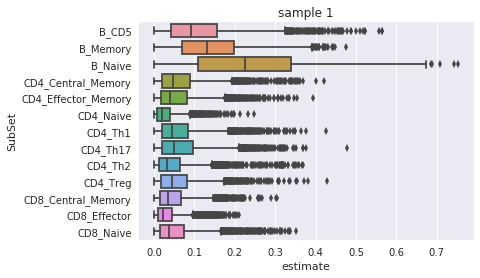

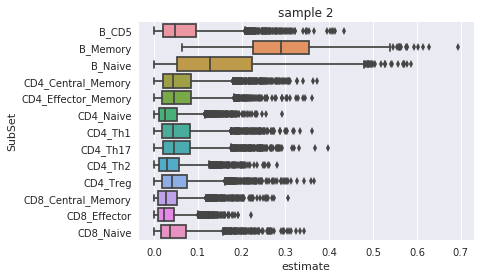

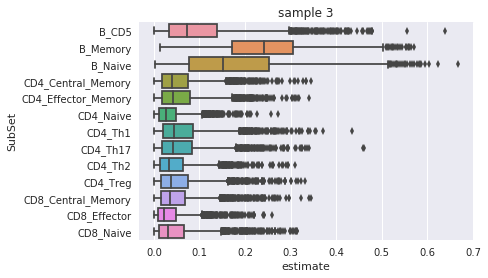

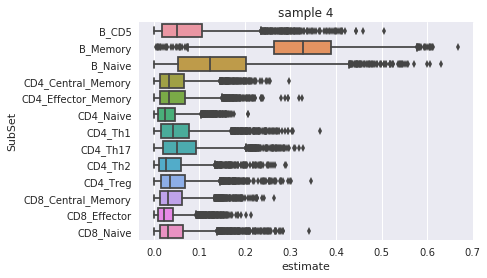

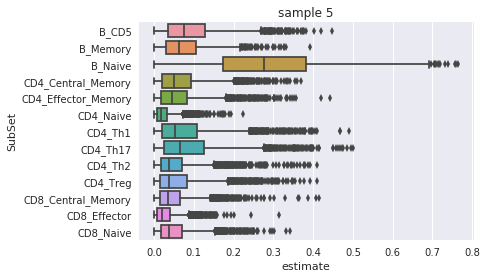

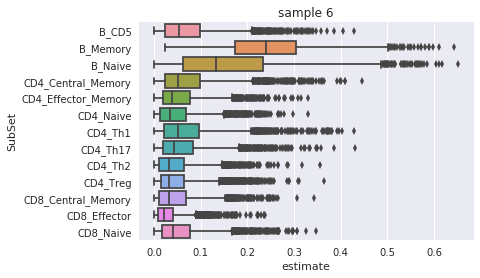

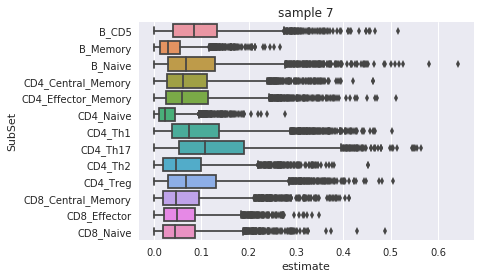

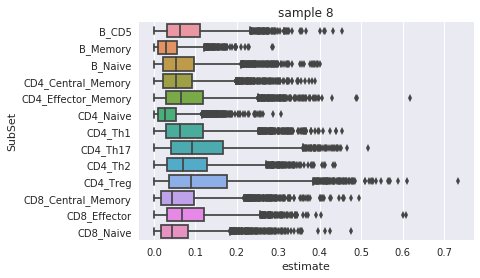

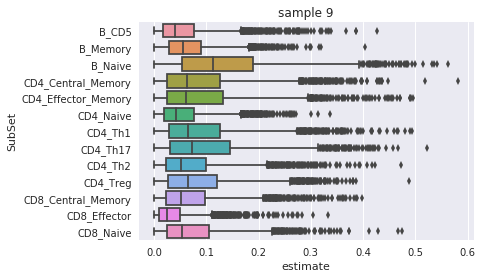

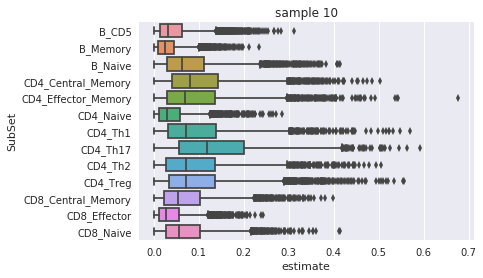

In [52]:
for key, grp in df.groupby('sample_id'):
    plt.figure()
    g = sns.boxplot(data=grp, y='SubSet', x='estimate')
    g.set_title('sample %d' % key)

What is the "true" cell type?

In [57]:
test_data['x2']

,SubSet[B_CD5],SubSet[B_Memory],SubSet[B_Naive],SubSet[CD4_Central_Memory],SubSet[CD4_Effector_Memory],SubSet[CD4_Naive],SubSet[CD4_Th1],SubSet[CD4_Th17],SubSet[CD4_Th2],SubSet[CD4_Treg],SubSet[CD8_Central_Memory],SubSet[CD8_Effector],SubSet[CD8_Naive]
0,0.0,0.50,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
0,0.0,0.50,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
0,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
0,0.0,0.75,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
0,0.0,0.25,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
0,0.0,0.25,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
0,0.0,0.00,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.0,0.0,0.0
0,0.0,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0
0,0.0,0.00,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.0,0.0,0.0
0,0.0,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0


In [56]:
#test_df['SubSet'].unique()

true_cell_type = test_data['x2'].transpose()
#true_cell_type[true_cell_type[0] > 0]
true_cell_type

,0,0,0,0,0,0,0,0,0,0
SubSet[B_CD5],0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
SubSet[B_Memory],0.5,0.5,0.75,0.75,0.25,0.25,0.0,0.00,0.0,0.00
SubSet[B_Naive],0.5,0.5,0.25,0.25,0.75,0.75,0.5,0.25,0.5,0.25
SubSet[CD4_Central_Memory],0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
SubSet[CD4_Effector_Memory],0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
SubSet[CD4_Naive],0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
SubSet[CD4_Th1],0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
SubSet[CD4_Th17],0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
SubSet[CD4_Th2],0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
SubSet[CD4_Treg],0.0,0.0,0.00,0.00,0.00,0.00,0.5,0.75,0.5,0.75


/home/maxim/anaconda2/envs/infil/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


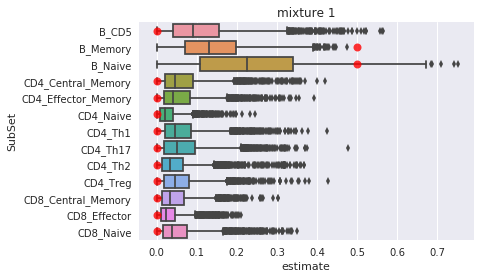

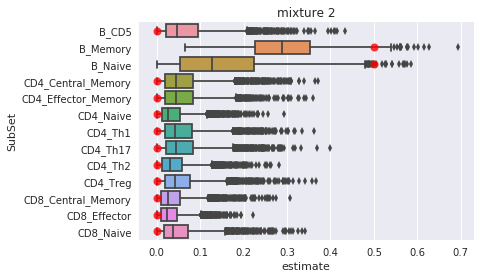

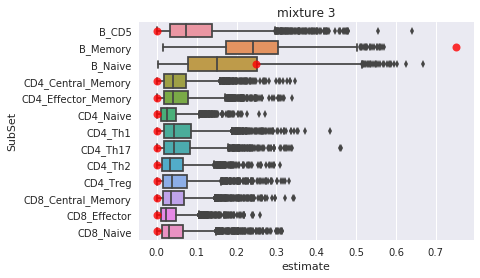

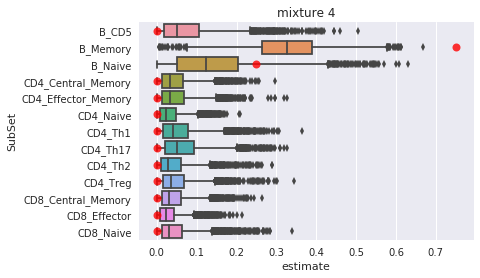

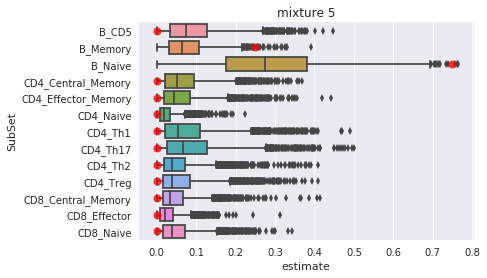

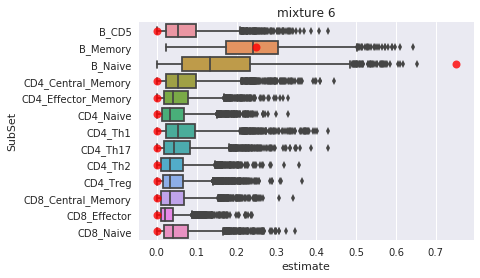

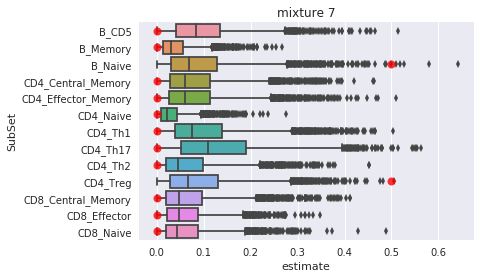

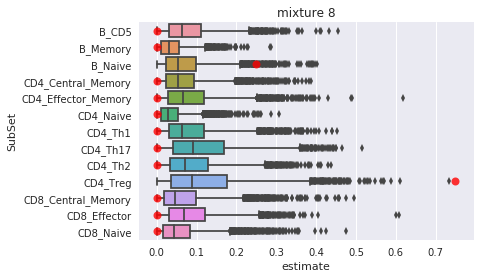

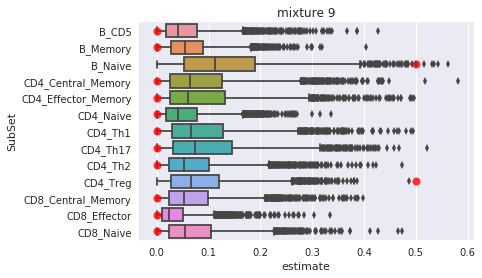

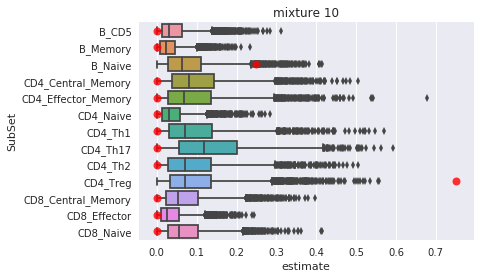

In [79]:
for (key, grp), (_, groundtruth) in zip(df.groupby('sample_id'), test_data['x2'].iterrows()):
    plt.figure()
    g = sns.boxplot(data=grp, y='SubSet', x='estimate')
    g.set_title('mixture %d' % key)
    
    # add groundtruth points
    gt = groundtruth.copy()
    gt.index = [s.replace('SubSet[', '').replace(']', '') for s in gt.index]
    gt = pd.DataFrame(gt).reset_index()
    gt.columns = ['SubSet', 'estimate']
    #print(gt)
    sns.stripplot(x="estimate", y="SubSet", data=gt,
                  linewidth=0,
                  #jitter=True,
                  #size=3,
                  #color=".3",
                  size=8,
                  color="r",
                  alpha=.8
                 )
    #break

In [89]:
def savefig(fig, *args, **kwargs):
    """
    Wrap figure.savefig defaulting to tight bounding box.
    From https://github.com/mwaskom/seaborn/blob/dfdd1126626f7ed0fe3737528edecb71346e9eb0/seaborn/axisgrid.py#L1840
    """
    kwargs.setdefault("bbox_inches", "tight")
    fig.savefig(*args, **kwargs)

/home/maxim/anaconda2/envs/infil/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/maxim/anaconda2/envs/infil/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


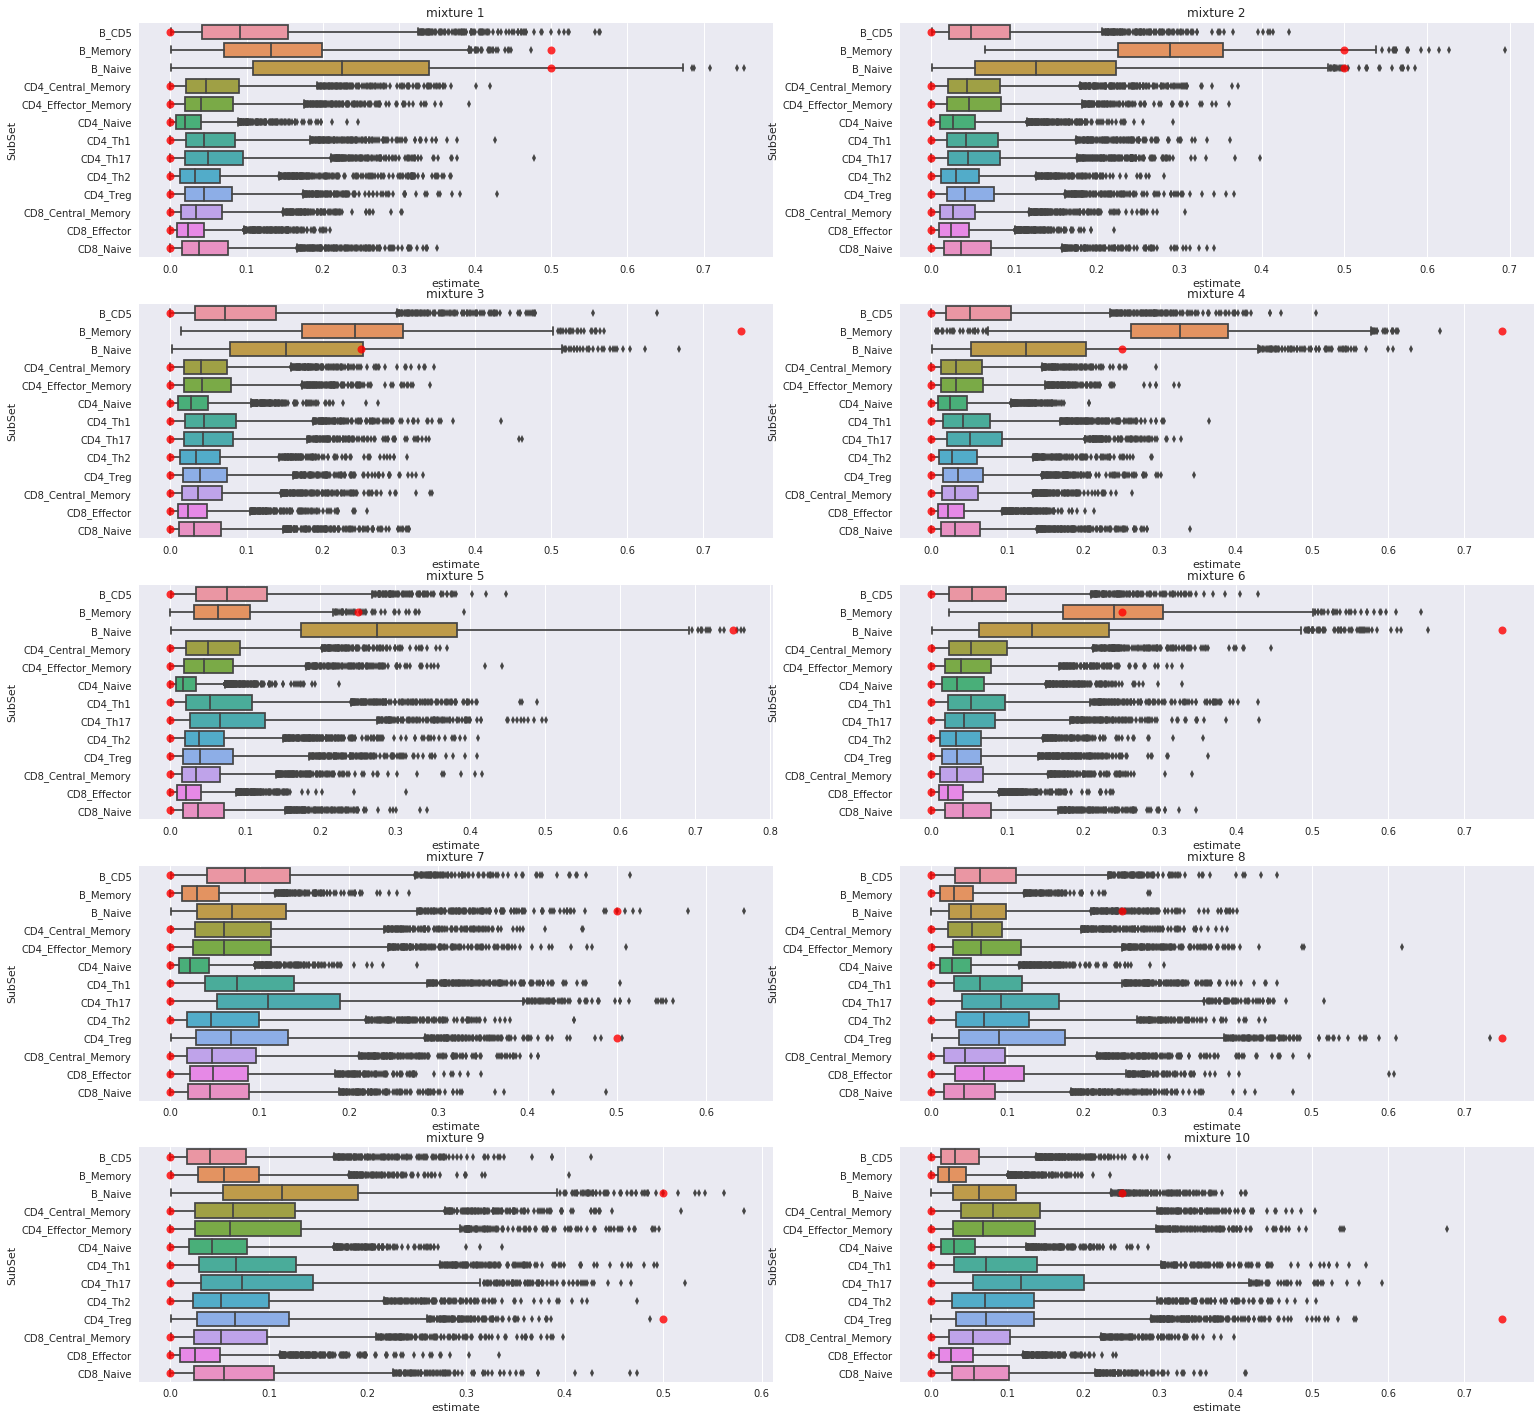

In [91]:
# use subplots
f, ax_arr = plt.subplots(5, 2, figsize=(25,25))

for (key, grp), (_, groundtruth), (axid, ax) in zip(df.groupby('sample_id'),
                                                    test_data['x2'].iterrows(),
                                                    np.ndenumerate(ax_arr)):
    #plt.figure()
    g = sns.boxplot(data=grp, y='SubSet', x='estimate', ax=ax)
    g.set_title('mixture %d' % key)
    
    # add groundtruth points
    gt = groundtruth.copy()
    gt.index = [s.replace('SubSet[', '').replace(']', '') for s in gt.index]
    gt = pd.DataFrame(gt).reset_index()
    gt.columns = ['SubSet', 'estimate']
    #print(gt)
    sns.stripplot(x="estimate", y="SubSet", data=gt,
                  ax=ax,
                  linewidth=0,
                  #jitter=True,
                  #size=3,
                  #color=".3",
                  size=8,
                  color="r",
                  alpha=.8
                 )
    #break
f.show()
savefig(f, 'plots/10mixtures_results.pdf', dpi=300)

## summarize posterior predictions by cell_type

In [26]:
cell_types = sample_df.drop_duplicates(subset=['cell_type','SubSet']).loc[:,['cell_type','SubSet']]
df2 = pd.merge(cell_types, df, on='SubSet')
df2 = df2.groupby(['cell_type','iter']).agg({'estimate': sum}).reset_index()

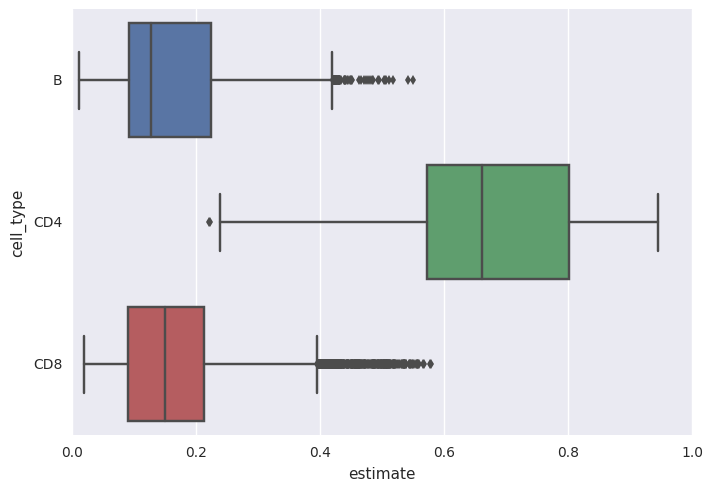

In [27]:
sns.boxplot(data=df2, y='cell_type', x='estimate')